In [1]:
import h5py
import healpy as hp
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
!ls -lsh /project/chihway/dhayaa/DECADE/Foreground_Masks/*

385M -rw-rw-r-- 1 dhayaa pi-chihway 385M Nov  5 10:07 /project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.05_Star5.fits
385M -rw-rw-r-- 1 dhayaa pi-chihway 385M Nov  5 10:04 /project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.1_Star5.fits
385M -rw-rw-r-- 1 dhayaa pi-chihway 385M Nov  5 10:19 /project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star10.fits
385M -rw-rw-r-- 1 dhayaa pi-chihway 385M Nov  5 10:22 /project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star20.fits
385M -rw-rw-r-- 1 dhayaa pi-chihway 385M Nov  5 10:10 /project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star3.fits
385M -rw-rw-r-- 1 dhayaa pi-chihway 385M Nov  5 10:13 /project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star4.fits
385M -rw-rw-r-- 1 dhayaa pi-chihway 385M Nov  5 10:16 /project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5.fits
385M -rw-rw-r-- 1 dhayaa pi-chihway 385M Nov  5 09:58 /project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.3_Star5.fi

In [3]:
!ls /scratch/midway3/dhayaa/SHEARTESTS/

Ext0.3_Star5  Ext0.4_Star5


In [4]:
PATHS = ['/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.4_Star5.fits',
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.3_Star5.fits',
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5.fits',
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.1_Star5.fits',
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.05_Star5.fits',
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star3.fits',
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star4.fits',
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5.fits',
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star10.fits',
         '/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star20.fits']

NAMES = ['Ext0.4_Star5',
         'Ext0.3_Star5',
         'Ext0.2_Star5',
         'Ext0.1_Star5',
         'Ext0.05_Star5',
         'Ext0.2_Star3',
         'Ext0.2_Star4',
         'Ext0.2_Star5',
         'Ext0.2_Star10',
         'Ext0.2_Star20']

for NAME, PATH in zip(NAMES, PATHS):
    
    GOLD_Foreground  = hp.read_map(PATH, dtype = int)
        
    path = '/scratch/midway3/dhayaa/SHEARTESTS/%s' % NAME
    os.system('mkdir %s' % path)
    
    with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20231002.hdf', 'r') as f:
        M = ((f['sg_bdf'][:] >= 4) & (f['mcal_s2n_noshear'][:] > 3) & 
             (f['mcal_T_ratio_noshear'][:] > 0.2) & (f['mcal_flags'][:] == 0))

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['RA'][:], f['DEC'][:], lonlat = True)]

        M = M & (FLAGS_Foreground ==  0)
        np.save(path + '/shear_inds.npy', np.where(M)[0])


    with h5py.File('/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5', 'r') as f:
        M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['ra'][:], f['dec'][:], lonlat = True)]

        M = M & (FLAGS_Foreground ==  0)
        
        inds = np.where(M)[0]
        Max_size = 100_000_000
        if len(inds) > Max_size:
            inds = np.random.default_rng(42).choice(inds, size = Max_size, replace = False)
            print("CHANGING LENGTH %d ---> %d" % (np.sum(M), len(inds)))
        
        np.save(path + '/psf_inds.npy', inds)
        
        
    JOB_TXT = """#!/bin/bash
#SBATCH --job-name ShearTests_%(NAME)s
#SBATCH --partition=caslake
#SBATCH --account=pi-chihway
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=48
#SBATCH --time=30:00:00
#SBATCH --output=/home/dhayaa/DECADE/shearcat/shear_tests/runs/%(NAME)s.log
#SBATCH --mail-user=dhayaa@uchicago.edu
#SBATCH --mail-type=BEGIN,END

#X=${TMPDIR}
#echo $TMPDIR
if [ "$USER" == "dhayaa" ]
then
    conda activate /project/chihway/dhayaa/MyEnvs_Midway3/shear
fi

shearcatalog=/project/chihway/data/decade/metacal_gold_combined_20230613.hdf
psfcatalog=/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5

RUN_DIR=/home/dhayaa/DECADE/shearcat/shear_tests

python -u $RUN_DIR/ShearTestRunner.py --psf_cat "/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5" \\
                                      --galaxy_cat "/project/chihway/data/decade/metacal_gold_combined_20231002.hdf" \\
                                      --psf_cat_inds "%(PSF_INDS)s" \\
                                      --galaxy_cat_inds "%(SHEAR_INDS)s" \\
                                      --output_path "%(OUTPUT)s" \\
                                      --sim_Cls_path "/project/chihway/dhayaa/DECADE/cosmosis/Lucas_files/Kappa_Cls.txt"

    """
    
    args = {'NAME' : NAME,
            'PSF_INDS' : path + '/psf_inds.npy',
            'SHEAR_INDS' : path + '/shear_inds.npy',
            'OUTPUT' : path}
    
    with open('runs/job_%s.sh' % NAME, 'w') as f:
        
        f.write(JOB_TXT % args)

    print("DONE WITH", NAME)

mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS/Ext0.4_Star5’: File exists
/scratch/local/jobs/10851023/ipykernel_4191796/1494271393.py:41: RuntimeWarning: invalid value encountered in true_divide
  M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)


CHANGING LENGTH 501848103 ---> 100000000
DONE WITH Ext0.4_Star5


mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS/Ext0.3_Star5’: File exists


CHANGING LENGTH 500110260 ---> 100000000
DONE WITH Ext0.3_Star5
CHANGING LENGTH 492572209 ---> 100000000
DONE WITH Ext0.2_Star5
CHANGING LENGTH 450514981 ---> 100000000
DONE WITH Ext0.1_Star5
CHANGING LENGTH 290713689 ---> 100000000
DONE WITH Ext0.05_Star5
CHANGING LENGTH 394274499 ---> 100000000
DONE WITH Ext0.2_Star3
CHANGING LENGTH 451233237 ---> 100000000
DONE WITH Ext0.2_Star4


mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS/Ext0.2_Star5’: File exists


CHANGING LENGTH 492572209 ---> 100000000
DONE WITH Ext0.2_Star5
CHANGING LENGTH 556845187 ---> 100000000
DONE WITH Ext0.2_Star10
CHANGING LENGTH 561033002 ---> 100000000
DONE WITH Ext0.2_Star20


# Check which component of mask is most important

In [5]:
BITS = [0, 1, 2, 4, 8, 16, 32, 64, 256, 1024, 2048]
BITS.append(np.sum(BITS))

for BIT in BITS:
    
        
    NAME = 'GOLD_OnlyBit%d' % BIT
    path = '/scratch/midway3/dhayaa/SHEARTESTS/%s' % NAME
    os.system('mkdir %s' % path)
    
    GOLD_Foreground  = hp.read_map('/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5.fits', dtype = int)
    
    with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20231002.hdf', 'r') as f:
        M = ((f['sg_bdf'][:] >= 4) & (f['mcal_s2n_noshear'][:] > 3) & 
             (f['mcal_T_ratio_noshear'][:] > 0.2) & (f['mcal_flags'][:] == 0))

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['RA'][:], f['DEC'][:], lonlat = True)]

        M = M & ((FLAGS_Foreground & BIT) == 0)
        np.save(path + '/shear_inds.npy', np.where(M)[0])


    with h5py.File('/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5', 'r') as f:
        M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['ra'][:], f['dec'][:], lonlat = True)]

        M = M & ((FLAGS_Foreground & BIT) == 0)
        
        inds = np.where(M)[0]
        Max_size = 100_000_000
        if len(inds) > Max_size:
            inds = np.random.default_rng(42).choice(inds, size = Max_size, replace = False)
            print("CHANGING LENGTH %d ---> %d" % (np.sum(M), len(inds)))
        
        np.save(path + '/psf_inds.npy', inds)
        
        
    JOB_TXT = """#!/bin/bash
#SBATCH --job-name ShearTests_%(NAME)s
#SBATCH --partition=caslake
#SBATCH --account=pi-chihway
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=48
#SBATCH --time=30:00:00
#SBATCH --output=/home/dhayaa/DECADE/shearcat/shear_tests/runs/%(NAME)s.log
#SBATCH --mail-user=dhayaa@uchicago.edu
#SBATCH --mail-type=BEGIN,END

#X=${TMPDIR}
#echo $TMPDIR
if [ "$USER" == "dhayaa" ]
then
    conda activate /project/chihway/dhayaa/MyEnvs_Midway3/shear
fi

shearcatalog=/project/chihway/data/decade/metacal_gold_combined_20230613.hdf
psfcatalog=/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5

RUN_DIR=/home/dhayaa/DECADE/shearcat/shear_tests

python -u $RUN_DIR/ShearTestRunner.py --psf_cat "/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5" \\
                                      --galaxy_cat "/project/chihway/data/decade/metacal_gold_combined_20231002.hdf" \\
                                      --psf_cat_inds "%(PSF_INDS)s" \\
                                      --galaxy_cat_inds "%(SHEAR_INDS)s" \\
                                      --output_path "%(OUTPUT)s" \\
                                      --sim_Cls_path "/project/chihway/dhayaa/DECADE/cosmosis/Lucas_files/Kappa_Cls.txt"

    """
    
    args = {'NAME' : NAME,
            'PSF_INDS' : path + '/psf_inds.npy',
            'SHEAR_INDS' : path + '/shear_inds.npy',
            'OUTPUT' : path}
    
    with open('runs/job_%s.sh' % NAME, 'w') as f:
        
        f.write(JOB_TXT % args)

    print("DONE WITH", NAME)

/scratch/local/jobs/10851023/ipykernel_4191796/3997682259.py:24: RuntimeWarning: invalid value encountered in true_divide
  M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)


CHANGING LENGTH 721323813 ---> 100000000
DONE WITH GOLD_OnlyBit0
CHANGING LENGTH 717013703 ---> 100000000
DONE WITH GOLD_OnlyBit1
CHANGING LENGTH 718287510 ---> 100000000
DONE WITH GOLD_OnlyBit2
CHANGING LENGTH 704195107 ---> 100000000
DONE WITH GOLD_OnlyBit4
CHANGING LENGTH 695707357 ---> 100000000
DONE WITH GOLD_OnlyBit8
CHANGING LENGTH 662159053 ---> 100000000
DONE WITH GOLD_OnlyBit16
CHANGING LENGTH 720495879 ---> 100000000
DONE WITH GOLD_OnlyBit32
CHANGING LENGTH 715949042 ---> 100000000
DONE WITH GOLD_OnlyBit64
CHANGING LENGTH 714754649 ---> 100000000
DONE WITH GOLD_OnlyBit256
CHANGING LENGTH 555503798 ---> 100000000
DONE WITH GOLD_OnlyBit1024
CHANGING LENGTH 629844847 ---> 100000000
DONE WITH GOLD_OnlyBit2048
CHANGING LENGTH 492572209 ---> 100000000
DONE WITH GOLD_OnlyBit3455


In [6]:
BITS = [1, 2, 4, 8, 16, 32, 64, 256, 1024, 2048]

TOTAL = np.sum(BITS)

for BIT in BITS:
    
#     GOLD_Foreground  = hp.read_map('/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5.fits', dtype = int)
        
    NAME = 'GOLD_WithoutBit%d' % BIT
    path = '/scratch/midway3/dhayaa/SHEARTESTS/%s' % NAME
    os.system('mkdir %s' % path)
    
    with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20231002.hdf', 'r') as f:
        M = ((f['sg_bdf'][:] >= 4) & (f['mcal_s2n_noshear'][:] > 3) & 
             (f['mcal_T_ratio_noshear'][:] > 0.2) & (f['mcal_flags'][:] == 0))

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['RA'][:], f['DEC'][:], lonlat = True)]

        M = M & ((FLAGS_Foreground & (TOTAL - BIT)) != 0)
        np.save(path + '/shear_inds.npy', np.where(M)[0])


    with h5py.File('/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5', 'r') as f:
        M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['ra'][:], f['dec'][:], lonlat = True)]

        M = M & ((FLAGS_Foreground & (TOTAL - BIT)) != 0)
        
        inds = np.where(M)[0]
        Max_size = 100_000_000
        if len(inds) > Max_size:
            inds = np.random.default_rng(42).choice(inds, size = Max_size, replace = False)
            print("CHANGING LENGTH %d ---> %d" % (np.sum(M), len(inds)))
        
        np.save(path + '/psf_inds.npy', inds)
        
        
    JOB_TXT = """#!/bin/bash
#SBATCH --job-name ShearTests_%(NAME)s
#SBATCH --partition=caslake
#SBATCH --account=pi-chihway
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=48
#SBATCH --time=30:00:00
#SBATCH --output=/home/dhayaa/DECADE/shearcat/shear_tests/runs/%(NAME)s.log
#SBATCH --mail-user=dhayaa@uchicago.edu
#SBATCH --mail-type=BEGIN,END

#X=${TMPDIR}
#echo $TMPDIR
if [ "$USER" == "dhayaa" ]
then
    conda activate /project/chihway/dhayaa/MyEnvs_Midway3/shear
fi

shearcatalog=/project/chihway/data/decade/metacal_gold_combined_20230613.hdf
psfcatalog=/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5

RUN_DIR=/home/dhayaa/DECADE/shearcat/shear_tests

python -u $RUN_DIR/ShearTestRunner.py --psf_cat "/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5" \\
                                      --galaxy_cat "/project/chihway/data/decade/metacal_gold_combined_20231002.hdf" \\
                                      --psf_cat_inds "%(PSF_INDS)s" \\
                                      --galaxy_cat_inds "%(SHEAR_INDS)s" \\
                                      --output_path "%(OUTPUT)s" \\
                                      --sim_Cls_path "/project/chihway/dhayaa/DECADE/cosmosis/Lucas_files/Kappa_Cls.txt"

    """
    
    args = {'NAME' : NAME,
            'PSF_INDS' : path + '/psf_inds.npy',
            'SHEAR_INDS' : path + '/shear_inds.npy',
            'OUTPUT' : path}
    
    with open('runs/job_%s.sh' % NAME, 'w') as f:
        
        f.write(JOB_TXT % args)

    print("DONE WITH", NAME)

/scratch/local/jobs/10851023/ipykernel_4191796/1975137130.py:24: RuntimeWarning: invalid value encountered in true_divide
  M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)


CHANGING LENGTH 228364164 ---> 100000000
DONE WITH GOLD_WithoutBit1
CHANGING LENGTH 228425366 ---> 100000000
DONE WITH GOLD_WithoutBit2
CHANGING LENGTH 225145550 ---> 100000000
DONE WITH GOLD_WithoutBit4
CHANGING LENGTH 227711340 ---> 100000000
DONE WITH GOLD_WithoutBit8
CHANGING LENGTH 209221895 ---> 100000000
DONE WITH GOLD_WithoutBit16
CHANGING LENGTH 228044310 ---> 100000000
DONE WITH GOLD_WithoutBit32
CHANGING LENGTH 225066163 ---> 100000000
DONE WITH GOLD_WithoutBit64
CHANGING LENGTH 225642931 ---> 100000000
DONE WITH GOLD_WithoutBit256
CHANGING LENGTH 160189994 ---> 100000000
DONE WITH GOLD_WithoutBit1024
CHANGING LENGTH 218689549 ---> 100000000
DONE WITH GOLD_WithoutBit2048


# DEC differences, due to airmass

In [8]:
GOLD_Foreground  = hp.read_map('/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5.fits', dtype = int)

for i in range(3):
    
    NAME = 'GOLD_DECpatch%d' % i
    path = '/scratch/midway3/dhayaa/SHEARTESTS/%s' % NAME
    os.system('mkdir %s' % path)

    with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20231002.hdf', 'r') as f:
        M = ((f['sg_bdf'][:] >= 4) & (f['mcal_s2n_noshear'][:] > 3) & 
             (f['mcal_T_ratio_noshear'][:] > 0.2) & (f['mcal_flags'][:] == 0))

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['RA'][:], f['DEC'][:], lonlat = True)]

        DEC_list = np.quantile(f['DEC'][:], [0, 1/3, 2/3,1])


        M = M & (FLAGS_Foreground == 0)  & ((f['DEC'][:] > DEC_list[i]) & (f['DEC'][:] < DEC_list[i +1]))
        np.save(path + '/shear_inds.npy', np.where(M)[0])


    with h5py.File('/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5', 'r') as f:
        M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['ra'][:], f['dec'][:], lonlat = True)]

        M = M & (FLAGS_Foreground == 0)  & ((f['dec'][:] > DEC_list[i]) & (f['dec'][:] < DEC_list[i +1]))
        
        inds = np.where(M)[0]
        Max_size = 100_000_000
        if len(inds) > Max_size:
            inds = np.random.default_rng(42).choice(inds, size = Max_size, replace = False)
            print("CHANGING LENGTH %d ---> %d" % (np.sum(M), len(inds)))
        else:
            print("NOT CHANGING LENGTH %d ---> %d" % (np.sum(M), len(inds)))
        
        np.save(path + '/psf_inds.npy', inds)


    JOB_TXT = """#!/bin/bash
#SBATCH --job-name ShearTests_%(NAME)s
#SBATCH --partition=caslake
#SBATCH --account=pi-chihway
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=48
#SBATCH --time=30:00:00
#SBATCH --output=/home/dhayaa/DECADE/shearcat/shear_tests/runs/%(NAME)s.log
#SBATCH --mail-user=dhayaa@uchicago.edu
#SBATCH --mail-type=BEGIN,END

#X=${TMPDIR}
#echo $TMPDIR
if [ "$USER" == "dhayaa" ]
then
    conda activate /project/chihway/dhayaa/MyEnvs_Midway3/shear
fi

shearcatalog=/project/chihway/data/decade/metacal_gold_combined_20230613.hdf
psfcatalog=/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5

RUN_DIR=/home/dhayaa/DECADE/shearcat/shear_tests

python -u $RUN_DIR/ShearTestRunner.py --psf_cat "/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5" \\
                                      --galaxy_cat "/project/chihway/data/decade/metacal_gold_combined_20231002.hdf" \\
                                      --psf_cat_inds "%(PSF_INDS)s" \\
                                      --galaxy_cat_inds "%(SHEAR_INDS)s" \\
                                      --output_path "%(OUTPUT)s" \\
                                      --sim_Cls_path "/project/chihway/dhayaa/DECADE/cosmosis/Lucas_files/Kappa_Cls.txt"

    """

    args = {'NAME' : NAME,
            'PSF_INDS' : path + '/psf_inds.npy',
            'SHEAR_INDS' : path + '/shear_inds.npy',
            'OUTPUT' : path}

    with open('runs/job_%s.sh' % NAME, 'w') as f:

        f.write(JOB_TXT % args)

    print("DONE WITH", NAME)

mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS/GOLD_DECpatch0’: File exists
/scratch/local/jobs/10851023/ipykernel_4191796/2936430452.py:23: RuntimeWarning: invalid value encountered in true_divide
  M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)


NOT CHANGING LENGTH 25873022 ---> 25873022
DONE WITH GOLD_DECpatch0


mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS/GOLD_DECpatch1’: File exists


CHANGING LENGTH 233634704 ---> 100000000
DONE WITH GOLD_DECpatch1


mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS/GOLD_DECpatch2’: File exists


CHANGING LENGTH 232808231 ---> 100000000
DONE WITH GOLD_DECpatch2


# Dependence on stellar density

In [9]:
STARS = hp.read_map('/home/dhayaa/DECADE/foreground_mask/data/stellar_density/gaia_stellar_density_G21_equ_n128_v0.fits')
STARS = hp.ud_grade(STARS, 4096)
AAAA = np.quantile(STARS[GOLD_Foreground == 0], [0, 1/3, 2/3,1])

In [10]:
AAAA

array([0.4673242 , 0.89890403, 1.7197001 , 4.99891281])

0.18525506059328714


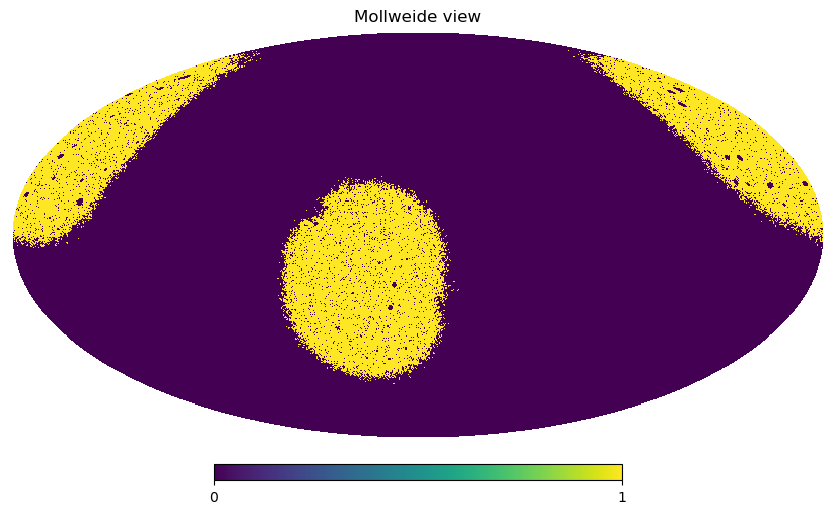

0.18484119574228922


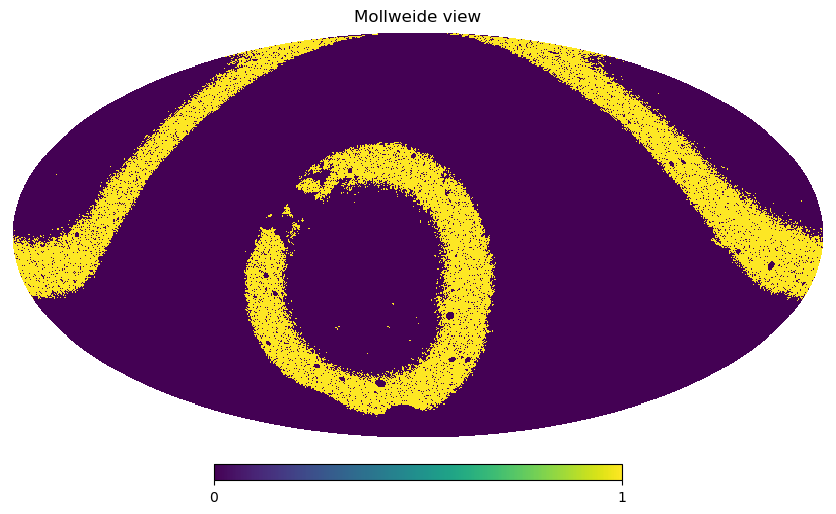

0.1851478318373362


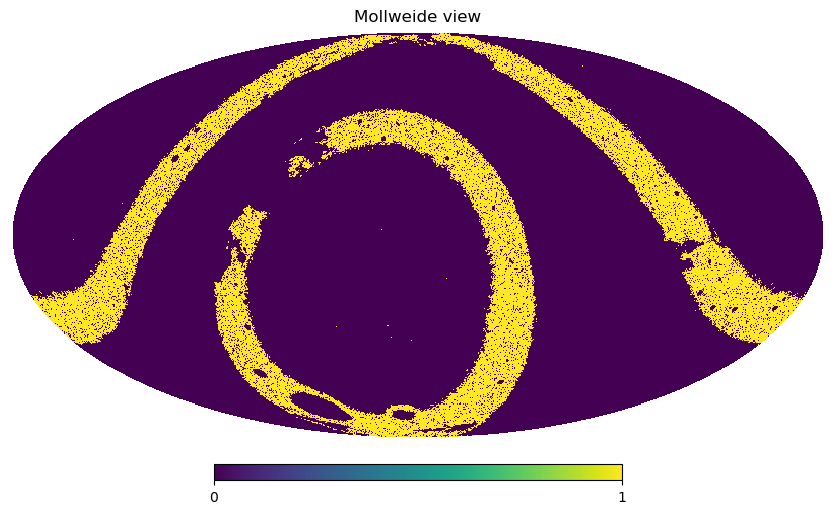

In [11]:
for i in range(3):
    maaa = (STARS > AAAA[i]) & (STARS < AAAA[i + 1]) & (GOLD_Foreground == 0)
    hp.mollview(maaa)
    print(np.average(maaa))
    plt.show()

In [13]:
GOLD_Foreground  = hp.read_map('/project/chihway/dhayaa/DECADE/Foreground_Masks/GOLD_Ext0.2_Star5.fits', dtype = int)
# STARS = hp.read_map('/home/dhayaa/DECADE/foreground_mask/data/stellar_density/gaia_stellar_density_G21_equ_n128_v0.fits')
# STARS = hp.ud_grade(STARS, 4096)

for i in range(3):
    
    NAME = 'GOLD_nstarpatch%d' % i
    path = '/scratch/midway3/dhayaa/SHEARTESTS/%s' % NAME
    os.system('mkdir %s' % path)

    with h5py.File('/project/chihway/data/decade/metacal_gold_combined_20231002.hdf', 'r') as f:
        M = ((f['sg_bdf'][:] >= 4) & (f['mcal_s2n_noshear'][:] > 3) & 
             (f['mcal_T_ratio_noshear'][:] > 0.2) & (f['mcal_flags'][:] == 0))

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['RA'][:], f['DEC'][:], lonlat = True)]
        STARS_DENSITY    = STARS[hp.ang2pix(hp.npix2nside(STARS.size), f['RA'][:], f['DEC'][:], lonlat = True)]
        STAR_list = np.quantile(STARS[GOLD_Foreground == 0], [0, 1/3, 2/3,1])


        M = M & (FLAGS_Foreground == 0)  & ((STARS_DENSITY > STAR_list[i]) & (STARS_DENSITY < STAR_list[i +1]))
        np.save(path + '/shear_inds.npy', np.where(M)[0])
        print(i, M.sum())


    with h5py.File('/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5', 'r') as f:
        M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)

        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), f['ra'][:], f['dec'][:], lonlat = True)]
        STARS_DENSITY    = STARS[hp.ang2pix(hp.npix2nside(STARS.size), f['ra'][:], f['dec'][:], lonlat = True)]
        
        M = M & (FLAGS_Foreground == 0)  & ((STARS_DENSITY > STAR_list[i]) & (STARS_DENSITY < STAR_list[i +1]))
        
        inds = np.where(M)[0]
        Max_size = 100_000_000
        if len(inds) > Max_size:
            inds = np.random.default_rng(42).choice(inds, size = Max_size, replace = False)
            print("CHANGING LENGTH %d ---> %d" % (np.sum(M), len(inds)))
        else:
            print("NOT CHANGING LENGTH %d ---> %d" % (np.sum(M), len(inds)))
        
        np.save(path + '/psf_inds.npy', inds)
        print(i, M.sum())


    JOB_TXT = """#!/bin/bash
#SBATCH --job-name ShearTests_%(NAME)s
#SBATCH --partition=caslake
#SBATCH --account=pi-chihway
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=48
#SBATCH --time=30:00:00
#SBATCH --output=/home/dhayaa/DECADE/shearcat/shear_tests/runs/%(NAME)s.log
#SBATCH --mail-user=dhayaa@uchicago.edu
#SBATCH --mail-type=BEGIN,END

#X=${TMPDIR}
#echo $TMPDIR
if [ "$USER" == "dhayaa" ]
then
    conda activate /project/chihway/dhayaa/MyEnvs_Midway3/shear
fi

shearcatalog=/project/chihway/data/decade/metacal_gold_combined_20230613.hdf
psfcatalog=/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5

RUN_DIR=/home/dhayaa/DECADE/shearcat/shear_tests

python -u $RUN_DIR/ShearTestRunner.py --psf_cat "/project/chihway/dhayaa/DECADE/star_psf_shapecatalog_20230510.hdf5" \\
                                      --galaxy_cat "/project/chihway/data/decade/metacal_gold_combined_20231002.hdf" \\
                                      --psf_cat_inds "%(PSF_INDS)s" \\
                                      --galaxy_cat_inds "%(SHEAR_INDS)s" \\
                                      --output_path "%(OUTPUT)s" \\
                                      --sim_Cls_path "/project/chihway/dhayaa/DECADE/cosmosis/Lucas_files/Kappa_Cls.txt"

    """

    args = {'NAME' : NAME,
            'PSF_INDS' : path + '/psf_inds.npy',
            'SHEAR_INDS' : path + '/shear_inds.npy',
            'OUTPUT' : path}

    with open('runs/job_%s.sh' % NAME, 'w') as f:

        f.write(JOB_TXT % args)

    print("DONE WITH", NAME)

mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS/GOLD_nstarpatch0’: File exists


0 55276189


/scratch/local/jobs/10851023/ipykernel_4191796/2127192339.py:26: RuntimeWarning: invalid value encountered in true_divide
  M = (f['FLUX_APER_8'][:]/f['FLUXERR_APER_8'][:] > 1)


NOT CHANGING LENGTH 69268782 ---> 69268782
0 69268782
DONE WITH GOLD_nstarpatch0


mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS/GOLD_nstarpatch1’: File exists


1 82499441
CHANGING LENGTH 197220794 ---> 100000000
1 197220794
DONE WITH GOLD_nstarpatch1


mkdir: cannot create directory ‘/scratch/midway3/dhayaa/SHEARTESTS/GOLD_nstarpatch2’: File exists


2 73498457
CHANGING LENGTH 225346113 ---> 100000000
2 225346113
DONE WITH GOLD_nstarpatch2
